# Importations

In [4]:
import tensorflow as tf
from tensorflow.keras.models import load_model as load_keras_model,Model,Sequential
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.activations import relu
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,RocCurveDisplay,roc_curve, roc_auc_score
from aizynthfinder.chem import *
from aizynthfinder.utils import *
from aizynthfinder.training import *
from aizynthfinder.context import *
from aizynthfinder.utils.models import LocalKerasModel
import numpy as np
import tqdm.notebook as tqdm
import SelectionGroup

# Modeles

# Récupération des Datas 

In [8]:
#Noms des Fichiers
fname_fp_false = "Nom du Fichier de ValidationData FINGERPRINT pour les Fausses Reactions"
fname_fp_true = "Nom du Fichier de ValidationData FINGERPRINT pour les Vraies Reactions"
fname_groups_false = "Nom du Fichier de ValidationData GROUPES pour les Fausses Reactions"
fname_groups_true = "Nom du Fichier de ValidationData GROUPES pour les Vraies Reactions"


In [9]:
#On charge les donnees
data_fp_false = pd.read_csv(fname_fp_false)
data_fp_true = pd.read_csv(fname_fp_true)
data_groups_false = pd.read_csv(fname_groups_false)
data_groups_true = pd.read_csv(fname_groups_true)

In [10]:
def fp_from_fp_db(fp_db):
    '''
    Cette fonction permet de recréer le fingerprint de taille 2048
    à partir du fingerprint codé en mémoire
    '''
    res = np.zeros(2048)
    #On initialise un array de 2048 zéros
    list_idx = fp_db.split(" ")
    #On récupère tous les indices non nuls du fingerprint
    for el in list_idx[:-1]:
        lfp = el.split("-")
        n = len(lfp)
        #En fonction des cas, on complète avec la bonne valeur
        if n == 1:
            res[int(lfp[0])] = 1
        elif n==2:
            res[int(lfp[0])] = int(lfp[-1])
        else:
            res[int(lfp[0])] = -int(lfp[-1])
    return res

def input_model_from_db(base_fp):
    '''
    Cette fonction renvoie un array de fingerprint à partir d'un dataset contenant des
    fingerprints sous forme "codée"
    '''
    #On sépare fingerprint de réactions et fingerprints du produit
    prod_fp_db,rxn_fp_db = base_fp["Product_Fingerprint"],base_fp["Reaction_Fingerprint"]
    prod_fp,rxn_fp = [],[]
    p_bar = tq.tqdm(total=base_fp.shape[0])
    for i in range(base_fp.shape[0]):
        #On essaie de récupérer le fingerprint associé à la ligne i
        try:
            p_bar.update(1)
            rxn_fp.append(fp_from_fp_db(rxn_fp_db.iloc[i]))
            prod_fp.append(fp_from_fp_db(prod_fp_db.iloc[i]))
        except:
            continue
    return np.array(prod_fp), np.array(rxn_fp)

In [27]:
def get_data(data_fp_false,data_fp_true,grps):
    res = []
    fp_grps = SelectionGroup.select_grp(data_fp_false,data_fp_true,grps)
    for prod_fp_false,rxn_fp_false,prod_fp_true,rxn_fp_true in fp_grps:
        prod_fp,rxn_fp = np.concatenate((prod_fp_false,prod_fp_true)),np.concatenate((rxn_fp_false,rxn_fp_true))
        labels = np.array([0]*prod_fp_false.shape[0]+[1]*prod_fp_true.shape[0])
        train_prop = 0.9
        test_prop  = 0.1
        assert(test_prop+train_prop==1)
        res.append(train_test_split(prod_fp, rxn_fp, labels, train_size = train_prop, random_state=41))
    return res

In [12]:
grp_correspondance = {"Aldehyde": "004",
         "Cetone":"005",
         "Enamine":"024",
         "Alcool":"028",
         "Phenol":"034",
         "Ether":"037",
         "Amine":"047",
         "Halogene":"061",
         "Acide Carboxylique":"076",
         "Lactone":"079",
         "Uree":"133",
         "Alcene":"199"}

In [13]:
reverse_grp_fp = {v: k for k, v in grp_correspondance.items()}

## Exemple avec la Lactone

In [59]:
data = get_data(data_fp_false, data_fp_true, ['Lactone'])

['C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/Groups_False_Reactions/Lactone_False_Reactions.csv']


  0%|          | 0/791 [00:00<?, ?it/s]

  0%|          | 0/13893 [00:00<?, ?it/s]

In [37]:
#On charge le modèle AiZynthFinder
mod_2 = tf.keras.models.load_model("../uspto_filter_model.hdf5")

In [60]:
#On charge notre modele
mod_1 = tf.keras.models.load_model("our_model_Lactone")

In [ ]:
#On prédit 
ai_pred = mod_2.predict([[data[0][1], data[0][3]]])
predictions = mod_1.predict([data[0][3], data[0][1]])

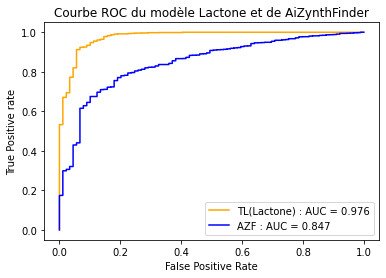

In [62]:
plot_roc_group(predictions, ai_pred , data[0][-1], 'Lactone')

## Fonction générique

In [66]:
def plot_curve(grp):
    data_ = get_data(data_fp_false, data_fp_true, [grp])
    mod_1 = tf.keras.models.load_model(f"our_model_{grp}")
    predictions = mod_1.predict([data_[0][3], data_[0][1]])
    ai_pred = mod_2.predict([[data_[0][1], data_[0][3]]])
    plot_roc_group(predictions, ai_pred , data_[0][-1], grp)

In [ ]:
def plot_curve_generator(grp):
    data_ = get_data(data_fp_false, data_fp_true, [grp])
    mod_1 = tf.keras.models.load_model(f"our_model_generator_{grp}")
    predictions = mod_1.predict([data_[0][3], data_[0][1]])
    ai_pred = mod_2.predict([[data_[0][1], data_[0][3]]])
    plot_roc_group(predictions, ai_pred , data_[0][-1], grp)

['C:/Users/Yassine/Desktop/PSC/PSC_final/Data/False_reactions/Groups_False_Reactions/Enamine_False_Reactions.csv']


  0%|          | 0/4104 [00:00<?, ?it/s]

  0%|          | 0/24000 [00:00<?, ?it/s]

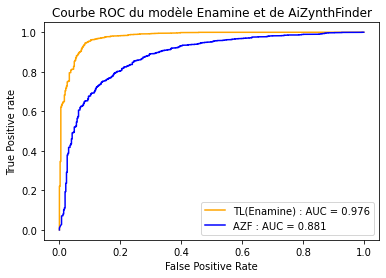

In [68]:
plot_curve('Enamine')